In [1]:
import pandas as pd
from prophet import Prophet

# Généralités sur les time series

## Analyse de séries temporelles



1.  Chargement
2.  Prétraitements
3.  Modèles descriptifs
4.  Modèles prédictifs



## Définition



Données avec une indexation temporelle

(peut être généré à partir de n'importe quelles donnéesayant au moins
un attribut chronologique)



## Séries temporelles régulières ou irrégulières



régulières → [fréquence d'échantillonnage](https://pandas.pydata.org/docs/reference/api/pandas.Series.asfreq.html)



## Autocorrélation



Relation linéaire entre le passé (immédiat) et le présent.
(~ régressionlinéaire sur une *fenêtre glissante*)



## Extrapolation vs Interpolation



-   Il est beaucoup plus difficilede prédire le futur que le passé !
    -   le découpage apprentissage / validation / test doit être chronologique
-   surtout le futur éloigné :
    -   (N pas plus loin vs 1 pas plus loin)



## Valeurs manquantes



Compte-tenu de l'auto-corrélation et de la nécessité d'avoir des
   séries temporelles régulières pour la plupart des algorithmes, il
   est souvent pertinent de faire de l'interpolation ou du *forward
   fill* pour remplacer les valeurs manquantes.



## Les dates ne snt pas simples



-   fuseaux horaires
-   années bissextiles
-   heure d'été / d'hiver
-   [seconde intercalaire](https://fr.wikipedia.org/wiki/Seconde_intercalaire)



## Attributs chronologiques



Enrichissement des données :

-   générique (e.g. jour de la semaine)
-   spécifique (e.g. vacances)



## Prévisibilité ?



# Exemple sur une série temporelle

## Exploration

In [2]:
df = pd.read_csv('rte.csv', parse_dates=["ds"], index_col=0)
df.sort_index(inplace=True)

In [3]:
df.head()

y
ds                        
2014-10-31 23:00:00  48288
2014-10-31 23:30:00  45467
2014-11-01 00:00:00  44904
2014-11-01 00:30:00  44041
2014-11-01 01:00:00  43393

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2014-10-31 23:00:00 to 2014-11-30 22:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1440 non-null   int64
dtypes: int64(1)
memory usage: 22.5 KB


In [5]:
df.sample(5)

y
ds                        
2014-11-05 17:30:00  69045
2014-11-07 08:30:00  65611
2014-11-23 16:00:00  51734
2014-11-30 15:30:00  53397
2014-11-21 22:30:00  58910

## Echantillonnage

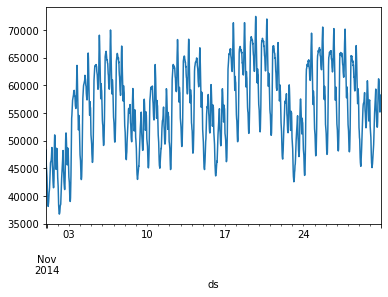

In [6]:
df['y'].plot();

In [7]:
df['y'].resample('D').mean().plot();

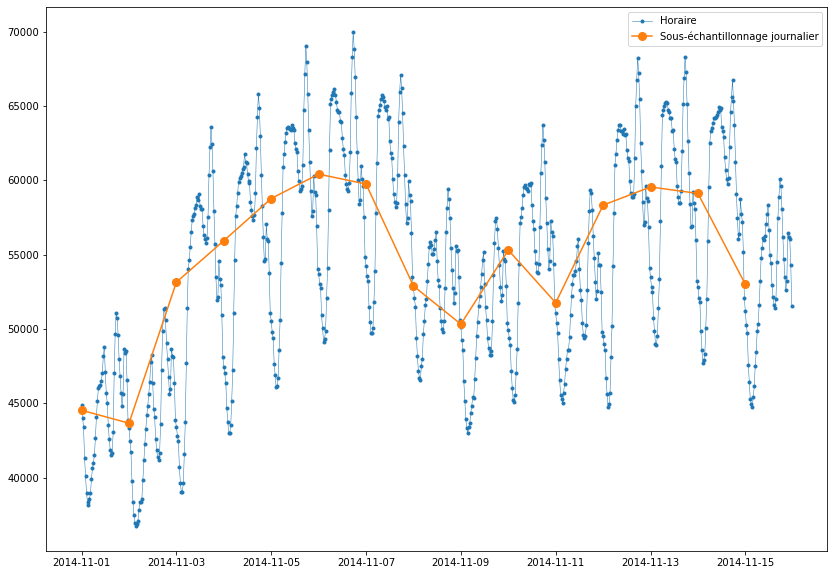

In [8]:
import matplotlib.pyplot as plt
start, end = '2014-11-01', '2014-11-15'
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(df.loc[start:end, 'y'], marker='.', linestyle='-', linewidth=0.5, label='Horaire')
ax.plot(df.resample('D').mean().loc[start:end, 'y'], marker='o', markersize=8, linestyle='-', label='Sous-échantillonnage journalier')
ax.legend();

## Tendance

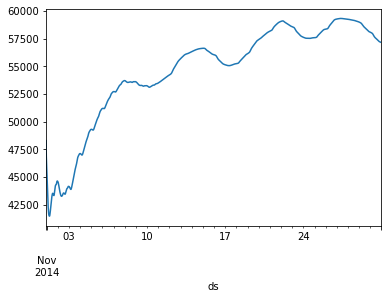

In [9]:
df['y'].rolling('10D').mean().plot();

## Composantes temporelles

In [10]:
df['day_of_week'] = df.index.day_of_week
df['day_name'] = df.index.day_name()
df['hour'] = df.index.hour

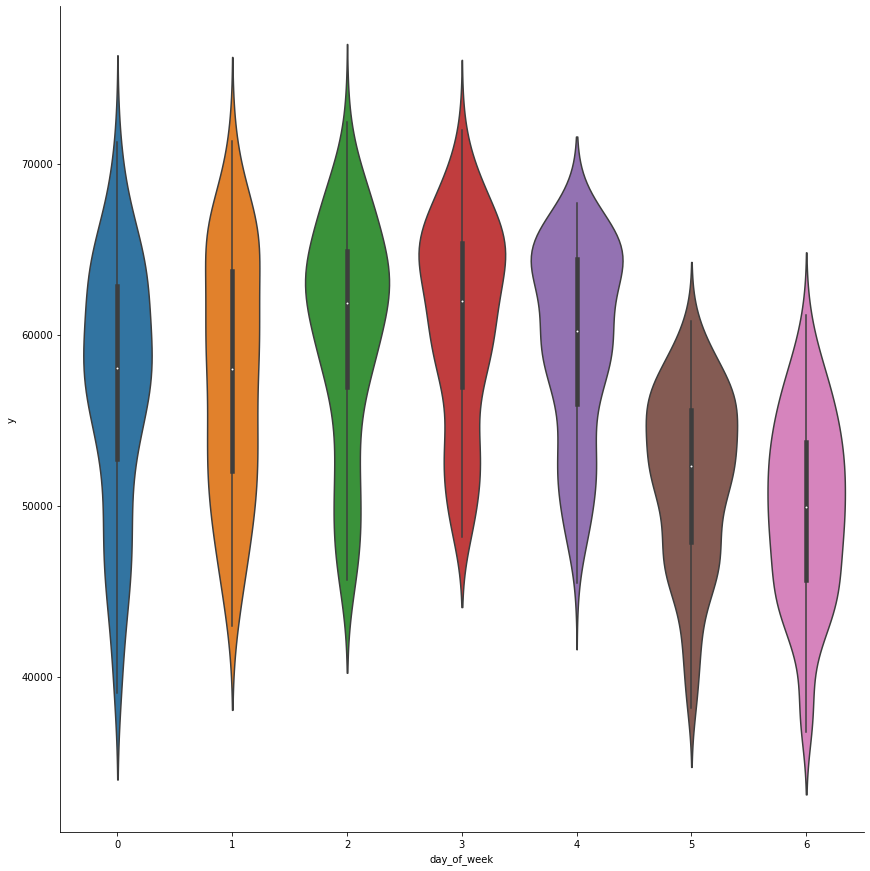

In [11]:
import seaborn as sns
sns.catplot(x='day_of_week', y='y', data=df, kind='violin', height=12, );

## Prophet
Ce qu'on voudrait, c'est pourvoir modéliser à la fois :

-   une tendance long terme, mais éventuellement avec des ruptures
-   plusieurs tendances cycliques
-   des évènements particuliers

On peut utiliser pour cela des [modèles additifs géneralisés](https://fr.wikipedia.org/wiki/Mod%C3%A8le_additif_g%C3%A9n%C3%A9ralis%C3%A9)
(Generalized Additive Model) et la [bibliothèque prophet](https://peerj.com/preprints/3190.pdf), [publiée par
Facebook](https://research.fb.com/prophet-forecasting-at-scale/), [implémente ce type de modèle](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a).

In [12]:
df = pd.read_csv('rte.csv')
df.head()

ds      y
0  2014-11-29 23:00:00  55430
1  2014-11-29 23:30:00  52613
2  2014-11-30 00:00:00  52039
3  2014-11-30 00:30:00  51257
4  2014-11-30 01:00:00  50614

### Model

In [13]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.5269


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4062.38    0.00562903        264.54           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4079.61    0.00396945       539.132       7.226     0.07226      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4088.74    0.00150906       184.698      0.6761      0.6761      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       4090.91   0.000184107       328.041   5.894e-07       0.001      436  LS failed, Hessian reset 
     399       4093.77   5.21179e-05       64.4288     0.09003           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       4094.71   0.000153244       238.778   1.392e-06       0.001      6

### Predictions

In [14]:
future = m.make_future_dataframe(periods=30)
future.tail()

ds
1465 2014-12-26 22:30:00
1466 2014-12-27 22:30:00
1467 2014-12-28 22:30:00
1468 2014-12-29 22:30:00
1469 2014-12-30 22:30:00

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower     yhat_upper
1465 2014-12-26 22:30:00  62477.338021  17300.396338   98979.587928
1466 2014-12-27 22:30:00  56014.902591   7556.946910   95529.112766
1467 2014-12-28 22:30:00  60247.839858   8881.854503  101117.960490
1468 2014-12-29 22:30:00  65597.208558  12317.964339  107939.160463
1469 2014-12-30 22:30:00  65630.518712   9408.935553  111239.544471

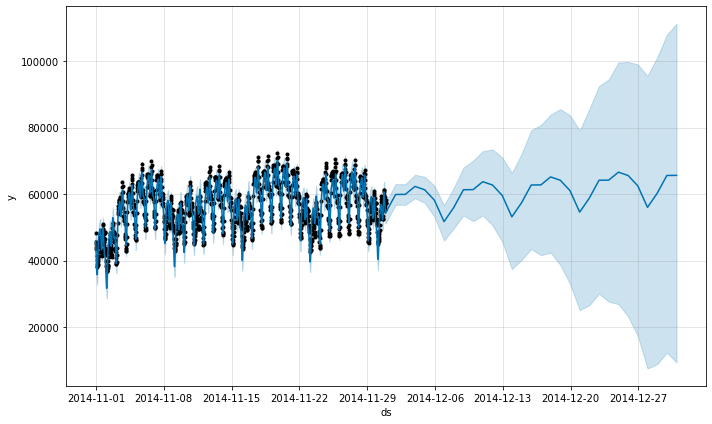

In [16]:
_ = m.plot(forecast)

### Composantes

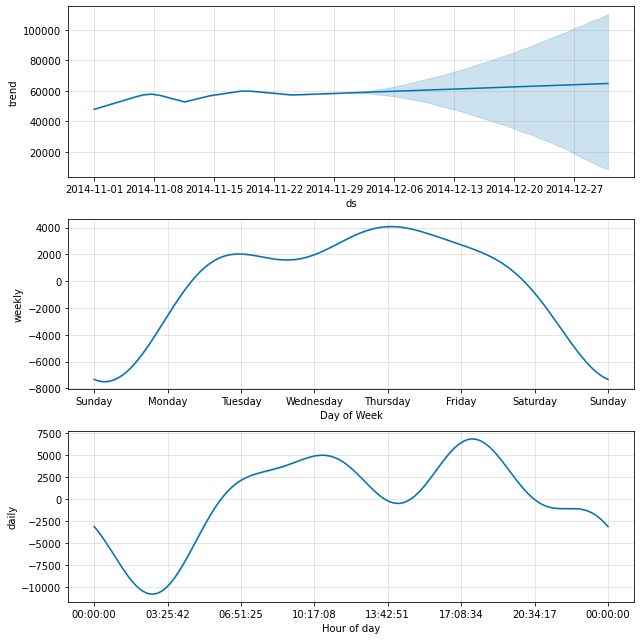

In [17]:
_ = m.plot_components(forecast)

# Times series avec DSS

Deux ressources :

- https://academy.dataiku.com/path/ml-practitioner/time-series-basics-1
- https://academy.dataiku.com/path/ml-practitioner/time-series-preparation-1


## Resampling

https://academy.dataiku.com/path/ml-practitioner/time-series-preparation-1/609907

## Interval extraction

https://academy.dataiku.com/path/ml-practitioner/time-series-preparation-1/610092

## Windowing

https://academy.dataiku.com/path/ml-practitioner/time-series-preparation-1/610097

## Extrema exctraction

https://academy.dataiku.com/path/ml-practitioner/time-series-preparation-1/610107

# Hands-on : consommation d'énergie en France (RTE)

- Téléchargez les données de 2019 : https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Annuel-Definitif_2019.zip
- Chargez les données dans dataiku, on va chercher à prédire la colonne `Consommation`
- Préparez le dataset et tracez la consommation en fonction de la date
- Dans la préparation, réalisez l'extraction des données temporelles
- Lancez un modèle de prédiction avec XGB
- Joignez les prévisions aux données historiques puis affichez les sur une même courbe (avec des couleurs différentes pour les valeurs historiques et prévisionnelles)